In [2]:
!pip install lime

     |████████████████████████████████| 275 kB 11.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=037e23e94b11c405f6a247b88ef3230fbcab0f75a543c91408402a7a0faa0776
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import train_test_split

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [4]:
senator_tweet_data = pd.read_csv('preprocessed_senator_tweet_data.csv')

In [5]:
from ast import literal_eval
senator_tweet_data.combined_text = senator_tweet_data.combined_text.apply(literal_eval)
# senator_tweet_data.timestamp = pd.to_datetime(senator_tweet_data.timestamp, format="%Y-%m-%d %H:%m:%S")
senator_tweet_data.hashtag = senator_tweet_data.hashtag.apply(literal_eval)
senator_tweet_data.clean_text = senator_tweet_data.clean_text.apply(literal_eval)

In [84]:
senator_tweet_data.combined_text.apply(len).max(), senator_tweet_data.combined_text.apply(len).min(), senator_tweet_data.combined_text.apply(len).mean()

(46, 0, 16.56891536223854)

In [6]:
senator_tweet_data = senator_tweet_data[senator_tweet_data.combined_text.apply(len) > 5]

In [86]:
senator_tweet_data.shape

(74235, 14)

In [87]:
senator_tweet_data.combined_text.apply(len).max(), senator_tweet_data.combined_text.apply(len).min(), senator_tweet_data.combined_text.apply(len).mean()

(46, 6, 17.497285646932042)

In [88]:
senator_tweet_data[senator_tweet_data.combined_text.apply(len) == 6].combined_text

129            [reopen, government, let, john, stick, day]
164      [caught, caroling, love, christmas, carol, fav...
179      [start, bill, sentencing, reform, applied, ret...
199      [natural, consequence, arrest, child, nowhere,...
309      [happy, halloween, chief, pawlicy, advisor, ha...
                               ...                        
79242    [congratulation, former, senior, advisor, robe...
79272      [watch, spoke, trial, american, pastor, andrew]
79301    [celebrating, year, service, usar, birthday, pic]
79366    [statement, senator, special, counsel, robert,...
79381    [outcome, hoped, great, season, march, madness...
Name: combined_text, Length: 1756, dtype: object

In [89]:
senator_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74235 entries, 0 to 79408
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     74235 non-null  int64 
 1   fullname       74235 non-null  object
 2   user           74235 non-null  object
 3   text           74235 non-null  object
 4   retweets       74235 non-null  int64 
 5   likes          74235 non-null  int64 
 6   replies        74235 non-null  int64 
 7   timestamp      74235 non-null  object
 8   party          74235 non-null  object
 9   hashtag        74235 non-null  object
 10  clean_text     74235 non-null  object
 11  Segmented#     27549 non-null  object
 12  combined_text  74235 non-null  object
 13  word_count     74235 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 8.5+ MB


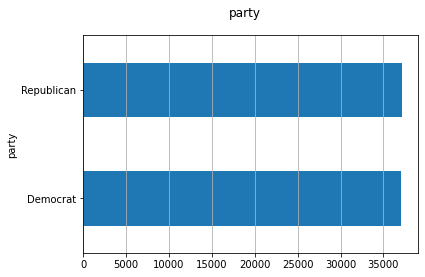

In [90]:
fig, ax = plt.subplots()
fig.suptitle("party", fontsize=12)
senator_tweet_data["party"].reset_index().groupby("party").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
senator_tweet_data.combined_text = senator_tweet_data.combined_text.apply(' '.join)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [92]:
senator_tweet_data.sample(5)

Unnamed: 0              fullname             user  \
59508       59508   Sen. James Lankford  SenatorLankford   
25850       25850   Sen. Jeanne Shaheen   SenatorShaheen   
77997       77997     Senator Roy Blunt         RoyBlunt   
5210         5210  Senator Cortez Masto   SenCortezMasto   
25807       25807   Sen. Jeanne Shaheen   SenatorShaheen   

                                                    text  retweets  likes  \
59508  Great to connect w/ the @NORMANCHAMBER while t...         3     15   
25850  One more reason why Sec. Nielsen should resign...       531    793   
77997  Today, @USDOT awarded a $25 million grant for ...         4     13   
5210   The BOLD Infrastructure for Alzheimer’s Act, w...        33    121   
25807  I have been astounded by the courage and persi...         8     19   

       replies            timestamp       party hashtag  \
59508        7  2018-03-06 22:54:28  Republican      []   
25850       42  2018-09-25 19:17:10    Democrat      []   
77997        2  2018-12-06 21:08:38  Republican      []   
5210         8  2019-01-03 01:15:00    Democrat      []   
25807        1  2018-10-09 15:30:52    Democrat      []   

                                              clean_text Segmented#  \
59508          [great, connect, w, theyre, visiting, dc]        NaN   
25850  [one, reason, sec, nielsen, resign, memo, prof...        NaN   
77997  [awarded, million, grant, buck, oneil, bridge,...        NaN   
5210   [bold, infrastructure, alzheimers, act, cowrot...        NaN   
25807  [astounded, courage, persistence, andrea, amic...        NaN   

                                           combined_text  word_count  
59508                 great connect w theyre visiting dc           6  
25850  one reason sec nielsen resign memo prof weve k...          28  
77997  awarded million grant buck oneil bridge replac...          17  
5210   bold infrastructure alzheimers act cowrote w w...          25  
25807  astounded courage persistence andrea amico pea...          17

In [300]:
## split dataset
df_train, df_test = train_test_split(senator_tweet_data, test_size=0.2, random_state=42, shuffle = True)

# df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, shuffle = True) # 0.25 x 0.8 = 0.2

## get target
y_train = df_train["party"].values
# y_val = df_val["party"].values
y_test = df_test["party"].values

### TF-IDF

In [94]:
## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=20000, ngram_range=(1,2))

In [95]:
corpus = df_train["combined_text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

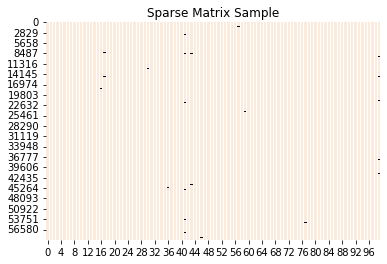

In [96]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

In [97]:
classifier = naive_bayes.MultinomialNB()

In [98]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["combined_text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.8
Auc: 0.89
Detail:
              precision    recall  f1-score   support

    Democrat       0.82      0.77      0.79      7465
  Republican       0.78      0.83      0.80      7382

    accuracy                           0.80     14847
   macro avg       0.80      0.80      0.80     14847
weighted avg       0.80      0.80      0.80     14847



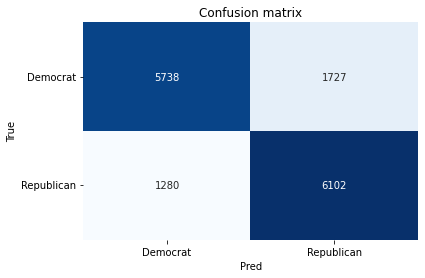

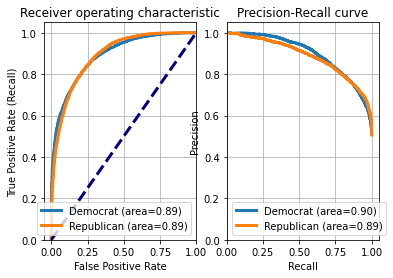

In [99]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])#, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [100]:
from sklearn import feature_selection
y = df_train["party"]
X_names = vectorizer.get_feature_names()
print("old feature length: ", len(X_names))
p_value_limit = 0.90
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


old feature length:  20000


In [101]:
print(len(X_names))

4343


In [102]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(df_features[df_features["y"]==cat]))
    print("  . top features:", ",".join(
df_features[df_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# Democrat:
  . selected features: 4343
  . top features: climate,climate change,must,preexisting,reform,shutdown,tax reform,trump,trump shutdown,worker
 
# Republican:
  . selected features: 4343
  . top features: climate,climate change,must,preexisting,reform,shutdown,tax reform,trump,trump shutdown,worker
 


In [103]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

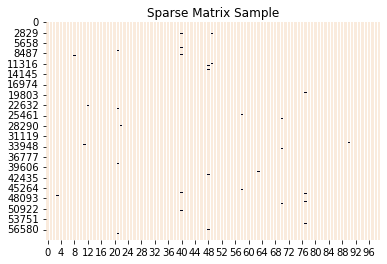

In [104]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

In [105]:
classifier = naive_bayes.MultinomialNB()

In [106]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["combined_text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.79
Auc: 0.88
Detail:
              precision    recall  f1-score   support

    Democrat       0.79      0.79      0.79      7465
  Republican       0.79      0.78      0.79      7382

    accuracy                           0.79     14847
   macro avg       0.79      0.79      0.79     14847
weighted avg       0.79      0.79      0.79     14847



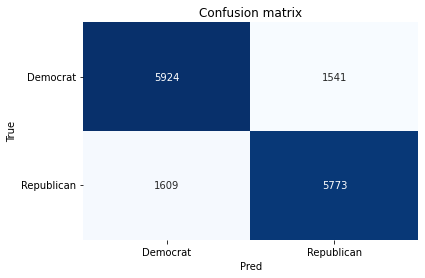

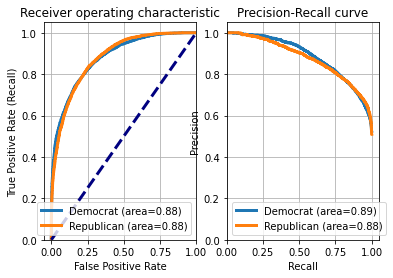

In [107]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])#, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [108]:
## select observation
i = 0
# i = 57
# i = 729
# i = 778
# i = 999
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Democrat --> Pred: Democrat | Prob: 0.64


In [110]:
## select observation
# i = 0
# i = 57
i = 729
# i = 778
# i = 999
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Democrat --> Pred: Democrat | Prob: 0.64


In [111]:
## select observation
# i = 0
# i = 57
# i = 729
i = 778
# i = 999
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Republican --> Pred: Republican | Prob: 0.71


In [112]:
## select observation
# i = 0
# i = 57
# i = 729
# i = 778
i = 999
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Democrat --> Pred: Republican | Prob: 0.54


### Word Embeddings

In [113]:
corpus = df_train["combined_text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

# lst_corpus = list(corpus)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [114]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [115]:
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


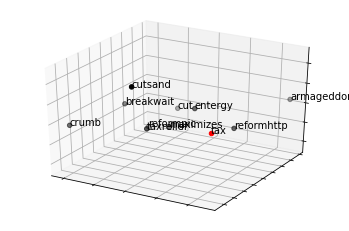

In [116]:
word = "tax"
fig = plt.figure()
# plt.figure(figsize=(2, 2))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=10)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [122]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=30, padding="post", truncating="post")

In [121]:
X_train.shape

(59388, 45)

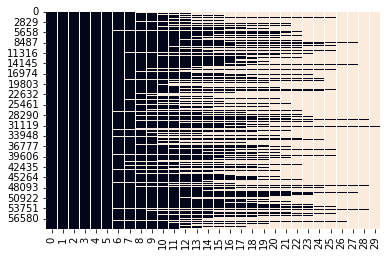

In [123]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [124]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(df_train["combined_text"].iloc[i].split())
print("from: ", df_train["combined_text"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", df_train["combined_text"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[df_train["combined_text"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  number question raised regarding protest directly outside washington c office opposition judge brett kavanaugh given attention ha received believe warrant response | len: 21
to:  [ 381  247 1686 1147 3053 1322 1384  170  443  139 1944   89  322   93
  822 1276    6  725  323 5872  369    0    0    0    0    0    0    0
    0    0] | len: 30
check:  number  -- idx in vocabulary --> 381
vocabulary:  {'NaN': 1, 'u': 2, 'senate': 3, 'bill': 4, 'wa': 5} ... (padding element, 0)


In [125]:
corpus = df_test["combined_text"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=30,
             padding="post", truncating="post")

In [126]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [127]:
word = "tax"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 30 |idx
embeddings[idx]: (300,) |vector


In [128]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(30,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=30, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=30)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 300)      11690700    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 30)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 30)      930         ['permute[0][0]']                
                                                                                              

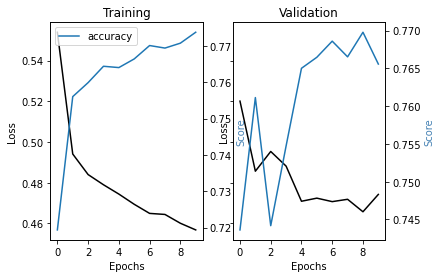

In [129]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [130]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [52]:
# dic_y_mapping = {n:label for n,label in 
#                  enumerate(np.unique(y_test))}
# inverse_dic = {v:k for k,v in dic_y_mapping.items()}
# y_test = np.array([inverse_dic[y] for y in y_test])

Accuracy: 0.71
Auc: 0.81
Detail:
              precision    recall  f1-score   support

    Democrat       0.81      0.54      0.65      7465
  Republican       0.65      0.87      0.75      7382

    accuracy                           0.71     14847
   macro avg       0.73      0.71      0.70     14847
weighted avg       0.73      0.71      0.70     14847



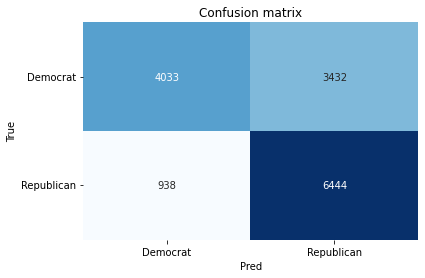

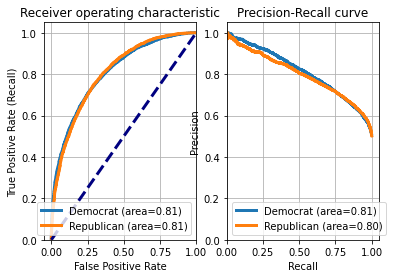

In [131]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])#, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

True: Democrat --> Pred: Republican | Prob: 0.79


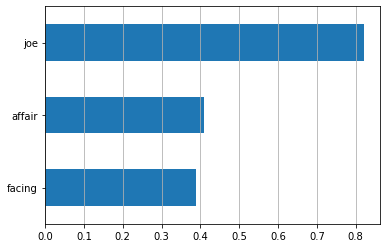

Text with highlighted words


In [133]:
## select observation
i = 999
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=30, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(3).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

True: Republican --> Pred: Republican | Prob: 0.87


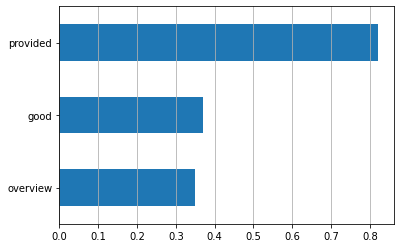

Text with highlighted words


In [134]:
## select observation
i = 778
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=30, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(3).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

True: Democrat --> Pred: Democrat | Prob: 0.71


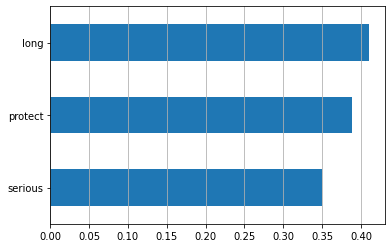

Text with highlighted words


In [136]:
## select observation
i = 0
txt_instance = df_test["combined_text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=30, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(3).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

### Language Models

In [178]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [289]:
corpus = df_train["text"].astype(str)
maxlen = 350

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP]" for txt in corpus]

encoded_input = tokenizer(corpus_tokenized, max_length = 350, padding="max_length", truncation=True)
idx = np.asarray(encoded_input.get('input_ids'), dtype='int32')
masks = np.asarray(encoded_input.get('attention_mask'), dtype='int32')
# segments = [[1 if x == 0 else 0 for x in m] for m in masks]
# for s in segments:
#   s[len(s) - sum(s) - 1] = 1
# segments = np.asarray(segments, dtype='int32')
X_train = [idx, masks] #, segments]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [292]:
i = 999
print("txt: ", df_train["text"].iloc[i])
# print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i]])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
# print("segment: ", X_train[2][i])

txt:  Wait, there’s more. Over 130 million Americans with diabetes, heart disease, and other pre-existing conditions could lose vital health insurance protections if #SCOTUS nominee Brett Kavanaugh is confirmed. It’s time to #StopKavanaugh.https://twitter.com/SenTinaSmith/status/1029824089257652224 …
idx:  [  101   101  3524  2045  1001  1001  1055  2062  2058  7558  2454  4841
  2007 14671  2540  4295  1998  2060  3653  1001  1001  4654  1001  1001
 21541  1001  1001 13749  3785  2071  4558  8995  2740  5427 28548  2065
  8040  1001  1001 27178  1001  1001  2149  9773 12049 10556  1001  1001
  3158  2050  1001  1001  1057  5603  2003  4484  2049  2051  2000  2644
  1001  1001 10556  1001  1001  3158  2050  1001  1001  1057  5603  1001
  1001  1044  2102  1001  1001  1056  2361  1001  1001  2358  1001  1001
 15536  1001  1001 23746  2121  1001  1001  4012  1001  1001 12411  1001
  1001 11958  1001  1001  3044  1001  1001  2358  2050  1001  1001 10722
  2015  1001  1001  2184  1001  100

In [293]:
corpus = df_test["text"].astype(str)
maxlen = 350

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP]" for txt in corpus]

encoded_input = tokenizer(corpus_tokenized, max_length = 350, padding="max_length", truncation=True)
idx = np.asarray(encoded_input.get('input_ids'), dtype='int32')
masks = np.asarray(encoded_input.get('attention_mask'), dtype='int32')
# segments = [[1 if x == 0 else 0 for x in m] for m in masks]
# for s in segments:
#   s[len(s) - sum(s) - 1] = 1
# segments = np.asarray(segments, dtype='int32')
X_test = [idx, masks] #, segments]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [268]:
import tensorflow as tf

In [294]:
## inputs
idx = layers.Input((350), dtype="int32", name="input_idx")
masks = layers.Input((350), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 350)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 350)]        0           []                               
                                                                                                  
 tf_distil_bert_model_7 (TFDist  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 350, 768),                                                   
                                 hidden_states=None                                         

In [303]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train

training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

650/650 [==============================] - 1556s 2s/step - loss: 0.5560 - accuracy: 0.7151 - val_loss: 0.5710 - val_accuracy: 0.7029


In [304]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

Accuracy: 0.71
Auc: 0.8
Detail:
              precision    recall  f1-score   support

    Democrat       0.81      0.55      0.65      7465
  Republican       0.65      0.87      0.75      7382

    accuracy                           0.71     14847
   macro avg       0.73      0.71      0.70     14847
weighted avg       0.73      0.71      0.70     14847



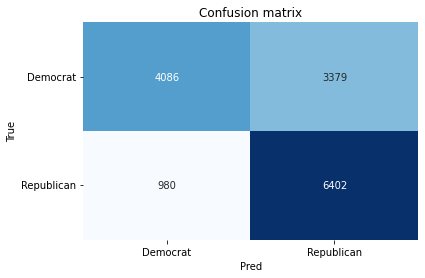

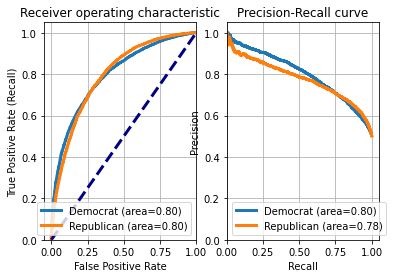

In [305]:
from sklearn import metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])#, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()